In [1]:
import torchaudio
from pathlib import Path

In [2]:
from torchaudio import transforms as T

In [3]:
data_dir = Path("/Users/benjamindecharmoy/projects/courtvision/data/frames")
clip_name = "Resumen-FINAL-MASCULINA--Santander-Santander-Sevilla-Master-A1-Padel-2023"
clip_audio = data_dir / clip_name / "audio.wav"
clip_frames = data_dir / clip_name
metadata = torchaudio.info(
    # "/Users/benjamindecharmoy/projects/courtvision/data/frames/El-PUNTAZO-de-las-Semifinales-del-Modon-Abu-Dhabi-Master-2023--World-Padel-Tour/audio.wav"
    data_dir
    / clip_name
    / "audio.wav"
)
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=41414656, num_channels=2, bits_per_sample=16, encoding=PCM_S)


In [4]:
waveform, sample_rate = torchaudio.load(clip_audio)
resample_rate = 8_000
resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
waveform = resampler(waveform)
sample_rate = resample_rate

In [5]:
import numpy
import torch
import matplotlib.pyplot as plt


def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform - hit")
    plt.show(block=False)


def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)

In [6]:
from IPython.display import Audio
import math
from PIL import Image, ImageOps


def grab_frame_at_time_n(
    time_seconds: int, sample_rate: int, last_frame_number: int = -1, colorize=False
) -> Image:
    fps = 30
    frame_number = math.ceil(time_seconds * fps) + 1
    if last_frame_number == frame_number and colorize is False:
        # print(f"skipping frame: {last_frame_number=} {frame_number=}")
        return None, last_frame_number
    # print(frame_number)
    image = Image.open(clip_frames / f"frame_{frame_number:04}.png")
    if colorize:
        green_tint = (
            0,
            255,
            0,
            77,
        )  # (R, G, B, A) values for the green tint with alpha = 0.3
        tinted_image = ImageOps.colorize(
            image.convert("L"), black=green_tint[:3], white=(255, 255, 255)
        )
        print("greeeeen")
        # blend the tinted image with the original image using an alpha value of 0.3
        return Image.blend(image, tinted_image, alpha=0.7), frame_number
    print(f"Normal frame: {last_frame_number=} {frame_number=}")
    return image, frame_number


def time_idx_to_sample_idx(time_seconds: int, sample_rate: int) -> int:
    return math.ceil(time_seconds * sample_rate)


start_time = 9 * 60 + 55.0
end_time = 9 * 60 + 55.4
offset_time = 30
channel_idx = 1


start_idx = time_idx_to_sample_idx(start_time, sample_rate=sample_rate)
end_idx = time_idx_to_sample_idx(end_time, sample_rate=sample_rate)
offset_idx = time_idx_to_sample_idx(offset_time, sample_rate=sample_rate)

hit_sample = waveform[channel_idx][start_idx:end_idx]

In [7]:
grab_frame_at_time_n(start_time, sample_rate=sample_rate)

Normal frame: last_frame_number=-1 frame_number=17851


(<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1280x720>, 17851)

In [8]:
Audio(hit_sample, rate=sample_rate)

In [9]:
import torch
import torch.nn.functional as F


def cross_correlation(x: torch.Tensor, y: torch.Tensor):
    """
    Convolution based corre
    """
    x = x.view(1, 1, -1) / x.view(1, 1, -1).max()
    y = y.view(1, 1, -1) / y.view(1, 1, -1).max()

    # Flip the shorter signal (X) to compute cross-correlation
    x = torch.flip(x, dims=[2])

    # Compute the convolution (cross-correlation) between X and Y
    result = F.conv1d(y, x)

    return result


result = cross_correlation(
    x=hit_sample,
    y=waveform[channel_idx][start_idx - offset_idx : start_idx + offset_idx],
)

In [ ]:
Audio(
    waveform[channel_idx][start_idx - offset_idx : start_idx + offset_idx],
    rate=sample_rate,
)

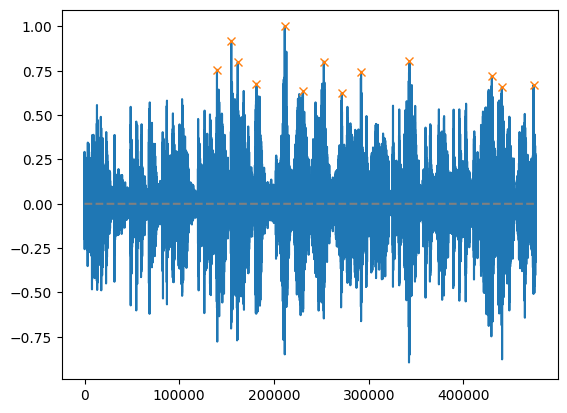

array([139829, 154929, 161704, 181542, 211354, 230626, 252591, 271566,
       291944, 343017, 429996, 440498, 473993])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# from scipy.datasets import electrocardiogram
from scipy.signal import find_peaks

x = result.squeeze(0).squeeze(0).numpy() / result.squeeze(0).squeeze(0).numpy().max()
peaks, _ = find_peaks(x=x, height=0.6, distance=sample_rate * 0.8)

plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

peaks

greeeeen


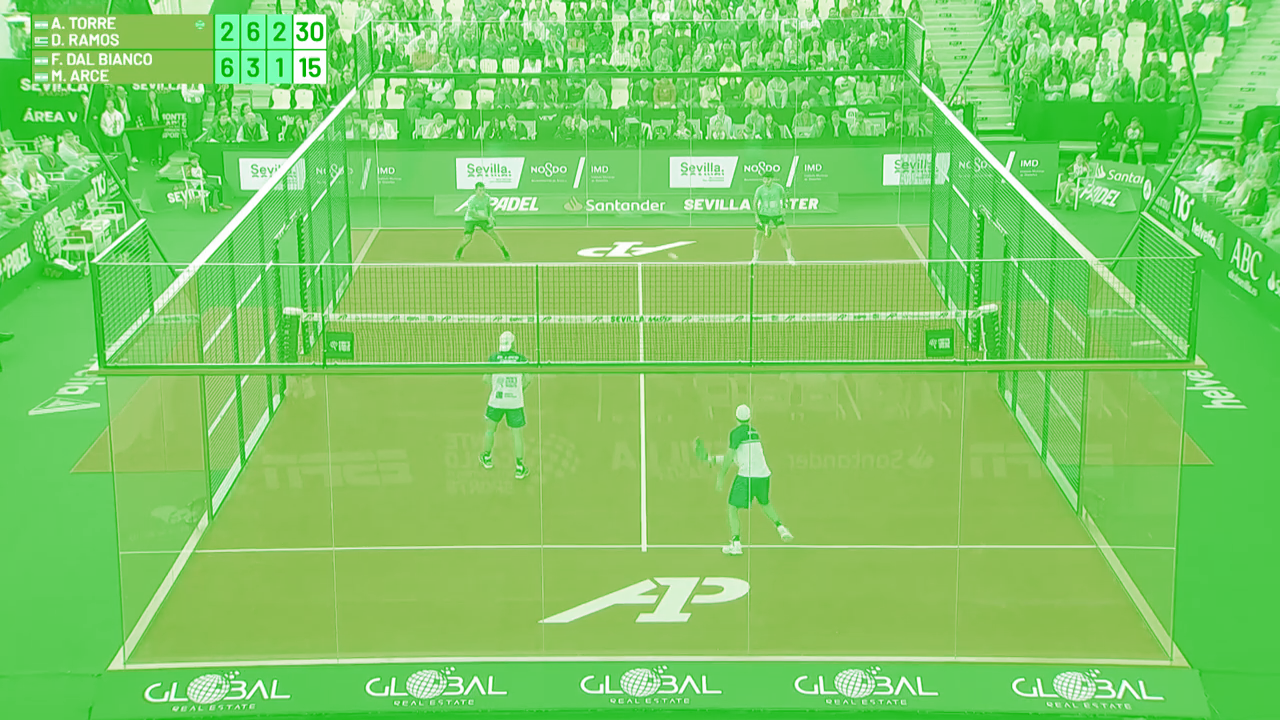

In [ ]:
frame, _ = grab_frame_at_time_n(
    peaks[5] / sample_rate + start_time,
    sample_rate=sample_rate,
    last_frame_number=-1,
    colorize=True,
)
frame

In [ ]:
any(abs(p - 3407) < 3 for p in peaks)

False

In [ ]:
import cv2


def make_subclip():
    output_file = "output.avi"
    frame_rate = 30
    last_frame_number = -1
    # get the size of the first image
    width, height = (1280, 720)

    # create the video writer object
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    writer = cv2.VideoWriter(output_file, fourcc, frame_rate, (width, height))

    # write each image to the video file

    # convert the PIL image to a NumPy array
    # write the frame to the video file

    # release the video writer object

    for time_idx in range(start_idx - offset_idx, start_idx + offset_idx):
        # print (time_idx-(start_idx-offset_idx))
        peak = time_idx - (start_idx - offset_idx)
        # print(f"Peak: {peak}")
        colorize = any(abs(p - peak) < 3 for p in peaks)
        if colorize:
            print(peak)
        image, last_frame_number = grab_frame_at_time_n(
            peak / sample_rate + start_time,
            sample_rate=sample_rate,
            last_frame_number=last_frame_number,
            colorize=colorize,
        )
        if image is None:
            continue
        width, height = image.size
        image_np = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        writer.write(image_np)

    writer.release()


make_subclip()

Normal frame: last_frame_number=-1 frame_number=17851
Normal frame: last_frame_number=17851 frame_number=17852
Normal frame: last_frame_number=17852 frame_number=17853
Normal frame: last_frame_number=17853 frame_number=17854
Normal frame: last_frame_number=17854 frame_number=17855
Normal frame: last_frame_number=17855 frame_number=17856
Normal frame: last_frame_number=17856 frame_number=17857
Normal frame: last_frame_number=17857 frame_number=17858
Normal frame: last_frame_number=17858 frame_number=17859
Normal frame: last_frame_number=17859 frame_number=17860
Normal frame: last_frame_number=17860 frame_number=17861
Normal frame: last_frame_number=17861 frame_number=17862
Normal frame: last_frame_number=17862 frame_number=17863
Normal frame: last_frame_number=17863 frame_number=17864
Normal frame: last_frame_number=17864 frame_number=17865
Normal frame: last_frame_number=17865 frame_number=17866
Normal frame: last_frame_number=17866 frame_number=17867
Normal frame: last_frame_number=17

In [21]:
import torch
import torch.nn.functional as F

# create a 1D tensor

# perform max pooling with a kernel size of 3 and a stride of 1
pooled = F.max_pool1d(result.float(), kernel_size=3, stride=1, padding=1)

# compare the pooled tensor with the original tensor to find local maxima
local_maxima = torch.eq(result.float(), pooled.squeeze())
sum(sum(sum(local_maxima)))

tensor(1050)

In [10]:
hit_sample.unsqueeze(0)

tensor([ 0.0329,  0.0163, -0.0042,  ..., -0.0317, -0.0500, -0.0049])

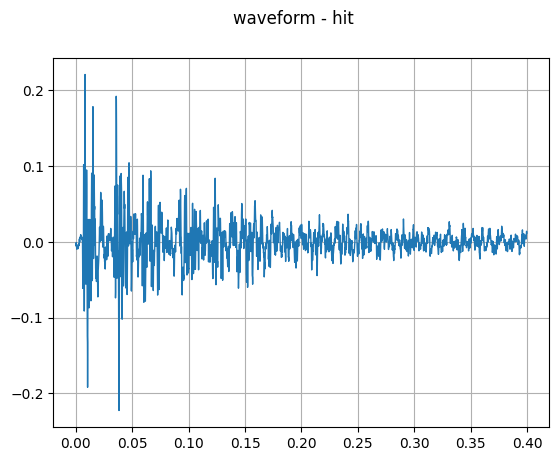

In [19]:
plot_waveform(hit_sample.unsqueeze(0), sample_rate=sample_rate)

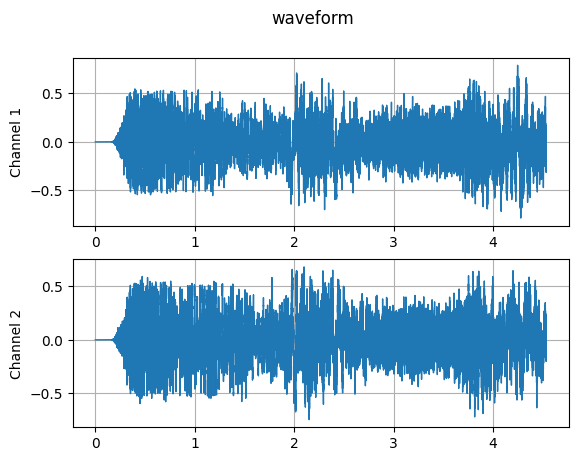

In [12]:
sample_waveform = waveform[:, 0:200000]
plot_waveform(sample_waveform, sample_rate)

/Users/benjamindecharmoy/projects/courtvision/.venv/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


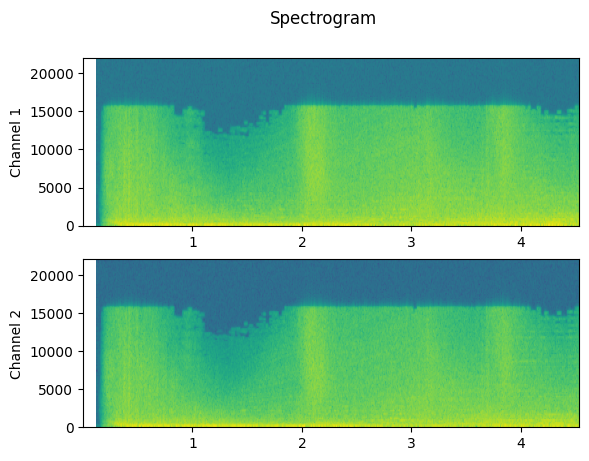

In [13]:
plot_specgram(sample_waveform, sample_rate)

In [9]:
waveform[:, 0:2000].shape

torch.Size([2, 2000])

In [76]:
17851 / 30

595.0333333333333

In [77]:
595.0333333333333 / 60

9.917222222222222